# MLP
MLP, K=5, epochs=200.
Use lncRNA.
Train set: filter none.
Valid set: filter none.
All transcripts per gene.

In [1]:
from datetime import datetime
print(datetime.now())

2023-04-04 13:46:51.944233


In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

GPU device not found
Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [3]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=5
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=200 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC
FILTER_TRAIN        = False
FILTER_TAILS_TRAIN  = False
FILTER_MIDDLE_TRAIN = False
FILTER_TEST         = False
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TEST  = False

Python 3.9.16
sklearn 1.2.2


In [4]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # else 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.all_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.all_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.all_lncRNA_transcripts.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [7]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(64, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(64, activation='sigmoid')
    layer3 = Dense(64, activation='sigmoid')
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(layer3)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return mlp

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-04-04 13:47:22.400214
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                65664     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 74,049
Trainable params: 74,049
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def save_model(self,filename):
        if self.model is not None:
            self.model.save(filename)
        
    def load_model(self,filename):
        self.model = keras.models.load_model(filename)
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # no validation
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, 
            validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [10]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            in_middle = gene_to_rci[gene_id] >= -2 and gene_to_rci[gene_id] <= 0
            in_tails = gene_to_rci[gene_id] < -2 or gene_to_rci[gene_id] > 0
            if gene_id in self.val_genes:
                if not FILTER_TEST or \
                    (FILTER_TAILS_TEST and in_middle) or \
                    (FILTER_MIDDLE_TEST and in_tails):
                    self.val_ids.append(allids[t])
                    self.val_seq.append(allseq[t])
                    self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                if not FILTER_TRAIN or \
                    (FILTER_TAILS_TRAIN and in_middle) or \
                    (FILTER_MIDDLE_TRAIN and in_tails):
                    self.train_ids.append(allids[t])
                    self.train_seq.append(allseq[t])
                    self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-04-04 13:47:23.054025
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.all_lncRNA_transcripts.csv
Loaded 19789 sequences.
2023-04-04 13:48:52.938990

Training # 1 1
2023-04-04 13:48:52.939278
2023-04-04 13:48:52.939342
Discriminator ZERO -1
Train 1:0 9157:6902 57.02%
Computed class weights: {0: 1.1633584468270066, 1: 0.8768701539805613}
Valid 1:0 2394:1336 64.18%
FIT
2023-04-04 13:48:53.113522


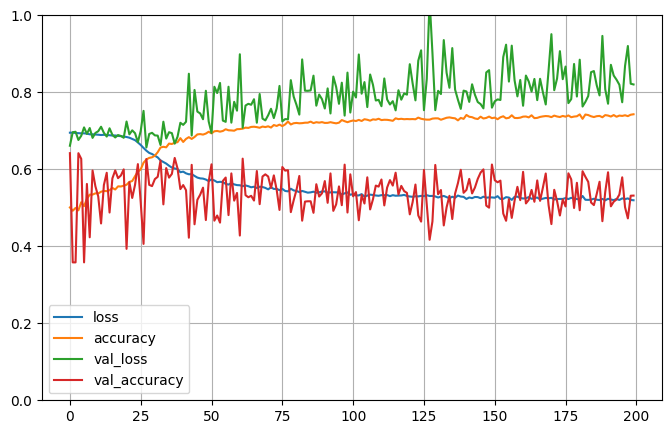


2023-04-04 13:55:16.649558

Testing # 1 1
2023-04-04 13:55:16.649680
2023-04-04 13:55:16.649807
PREDICT
2023-04-04 13:55:16.699158
Test 1:0 2394:1336 64.18%
Predict 1:0 1943:1787 52.09%
Test sizes (3730, 1025) (3730,)
Range of scores: 0.0005891661 to 0.9999929
Score threshold 0.5
Confusion matrix
 [[ 688  648]
 [1099 1295]]
Normalized matrix
 [[0.1844504  0.17372654]
 [0.29463807 0.34718499]]


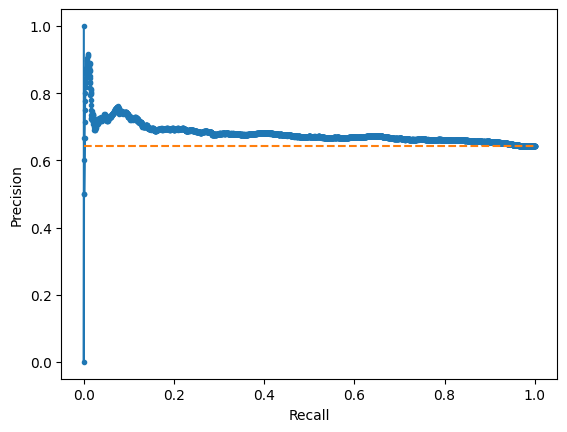

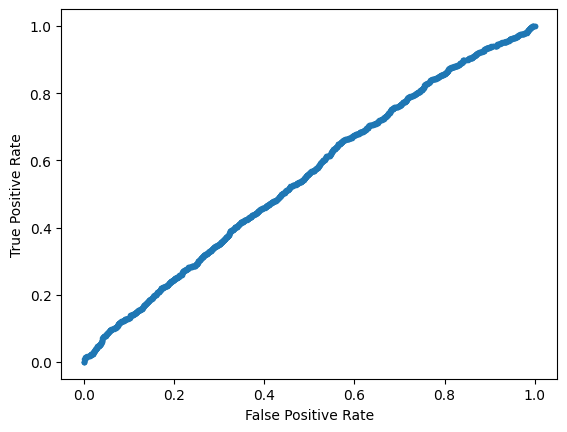

Accuracy: 53.16% Precision: 66.65% Recall: 54.09%
F1: 59.72% MCC: 0.0537
AUPRC: 67.94% AUROC: 54.96%
 accuracy [53.16353887399464]
 precision [66.64951106536284]
 recall [54.09356725146199]
 F1 [59.71869956190916]
 MCC [0.053656577409216685]
 AUPRC [67.94100223910038]
 AUROC [54.96174005372714]
2023-04-04 13:55:18.183468

Training # 1 2
2023-04-04 13:55:18.184606
2023-04-04 13:55:18.184678
Discriminator ZERO -1
Train 1:0 9192:6608 58.18%
Computed class weights: {0: 1.1955205811138014, 1: 0.8594429939077458}
Valid 1:0 2359:1630 59.14%
FIT
2023-04-04 13:55:18.446250


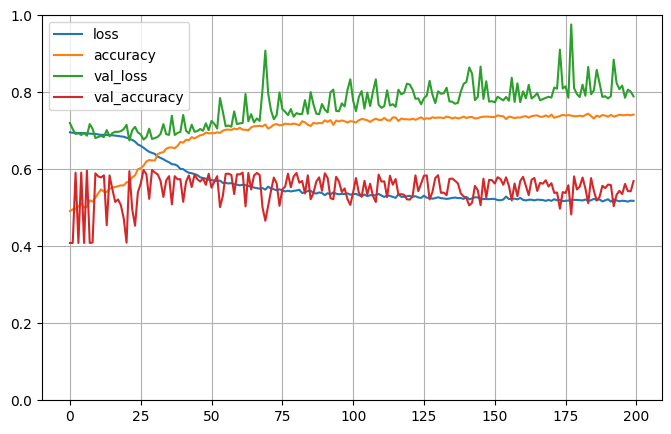


2023-04-04 14:01:07.243832

Testing # 1 2
2023-04-04 14:01:07.243957
2023-04-04 14:01:07.244003
PREDICT
2023-04-04 14:01:07.281307
Test 1:0 2359:1630 59.14%
Predict 1:0 2957:1032 74.13%
Test sizes (3989, 1025) (3989,)
Range of scores: 0.00032469546 to 0.99833834
Score threshold 0.5
Confusion matrix
 [[ 472 1158]
 [ 560 1799]]
Normalized matrix
 [[0.11832539 0.29029832]
 [0.14038606 0.45099022]]


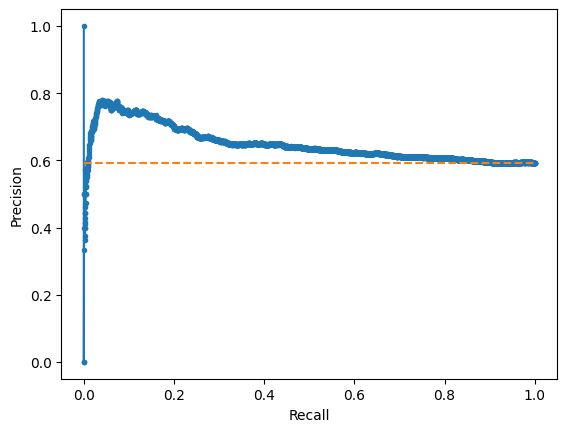

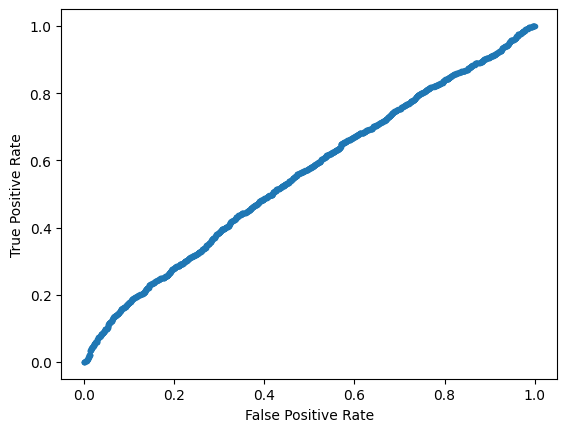

Accuracy: 56.93% Precision: 60.84% Recall: 76.26%
F1: 67.68% MCC: 0.0586
AUPRC: 64.72% AUROC: 55.77%
 accuracy [56.93156179493607]
 precision [60.83868785931688]
 recall [76.26112759643917]
 F1 [67.68246802106847]
 MCC [0.058574899431330193]
 AUPRC [64.71578196870844]
 AUROC [55.76655908581415]
2023-04-04 14:01:08.701961

Training # 1 3
2023-04-04 14:01:08.703657
2023-04-04 14:01:08.703726
Discriminator ZERO -1
Train 1:0 9431:6740 58.32%
Computed class weights: {0: 1.1996290801186944, 1: 0.8573322023115258}
Valid 1:0 2120:1498 58.60%
FIT
2023-04-04 14:01:08.886724


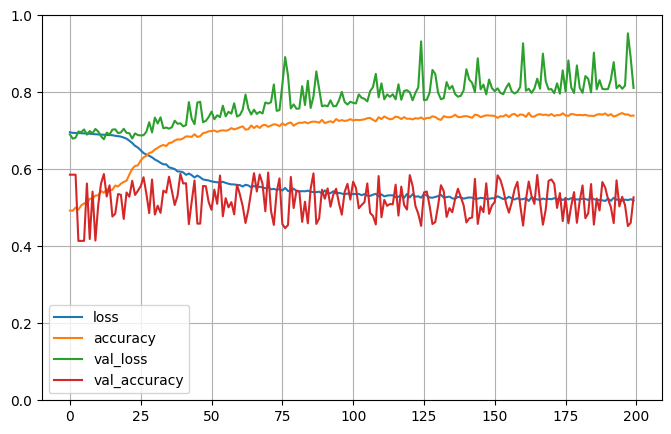


2023-04-04 14:07:32.232296

Testing # 1 3
2023-04-04 14:07:32.234943
2023-04-04 14:07:32.235483
PREDICT
2023-04-04 14:07:32.263746
Test 1:0 2120:1498 58.60%
Predict 1:0 2289:1329 63.27%
Test sizes (3618, 1025) (3618,)
Range of scores: 0.0016645652 to 0.99416
Score threshold 0.5
Confusion matrix
 [[ 558  940]
 [ 771 1349]]
Normalized matrix
 [[0.15422886 0.25981205]
 [0.21310116 0.37285793]]


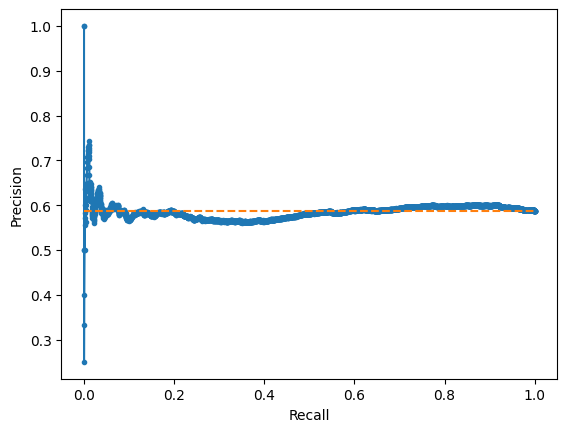

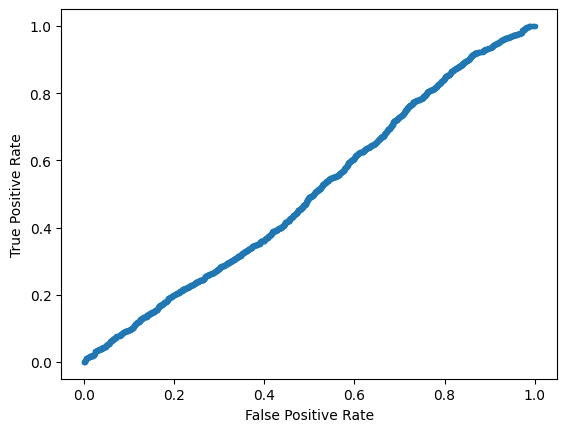

Accuracy: 52.71% Precision: 58.93% Recall: 63.63%
F1: 61.19% MCC: 0.0090
AUPRC: 58.53% AUROC: 50.38%
 accuracy [52.708678828081815]
 precision [58.93403232852774]
 recall [63.632075471698116]
 F1 [61.19301428895441]
 MCC [0.009009067218978031]
 AUPRC [58.52838759154167]
 AUROC [50.37688616268231]
2023-04-04 14:07:33.425079

Training # 1 4
2023-04-04 14:07:33.425324
2023-04-04 14:07:33.425381
Discriminator ZERO -1
Train 1:0 9175:6738 57.66%
Computed class weights: {0: 1.1808400118729594, 1: 0.8671934604904632}
Valid 1:0 2376:1500 61.30%
FIT
2023-04-04 14:07:33.612444


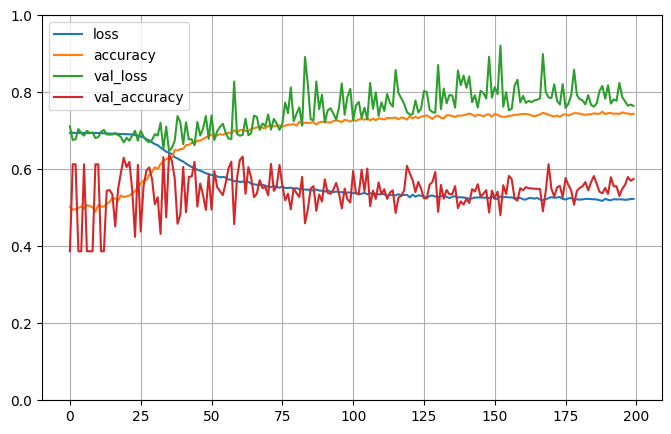


2023-04-04 14:13:56.836706

Testing # 1 4
2023-04-04 14:13:56.836842
2023-04-04 14:13:56.836898
PREDICT
2023-04-04 14:13:56.872267
Test 1:0 2376:1500 61.30%
Predict 1:0 2662:1214 68.68%
Test sizes (3876, 1025) (3876,)
Range of scores: 0.0006994302 to 0.99873686
Score threshold 0.5
Confusion matrix
 [[ 533  967]
 [ 681 1695]]
Normalized matrix
 [[0.1375129  0.249484  ]
 [0.17569659 0.4373065 ]]


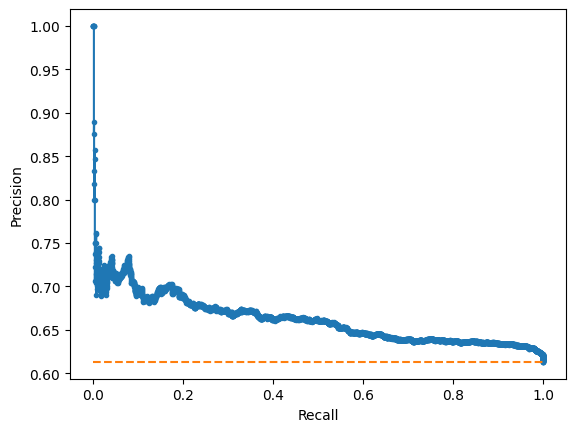

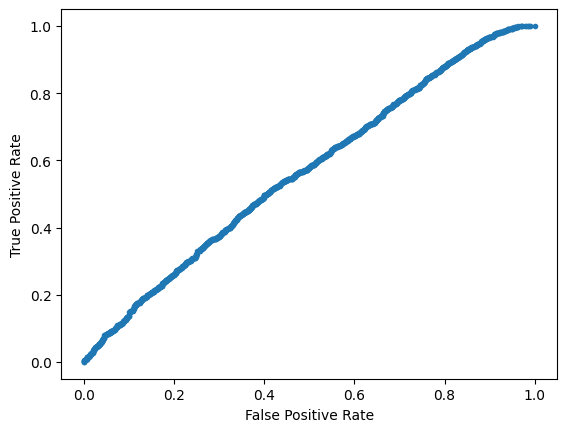

Accuracy: 57.48% Precision: 63.67% Recall: 71.34%
F1: 67.29% MCC: 0.0722
AUPRC: 66.24% AUROC: 56.68%
 accuracy [57.48194014447885]
 precision [63.67392937640871]
 recall [71.33838383838383]
 F1 [67.28860658991664]
 MCC [0.07216402613196621]
 AUPRC [66.24026158886814]
 AUROC [56.68187429854097]
2023-04-04 14:13:58.139653

Training # 1 5
2023-04-04 14:13:58.141705
2023-04-04 14:13:58.141794
Discriminator ZERO -1
Train 1:0 9249:5964 60.80%
Computed class weights: {0: 1.2754024144869216, 1: 0.8224132338631204}
Valid 1:0 2302:2274 50.31%
FIT
2023-04-04 14:13:58.324837


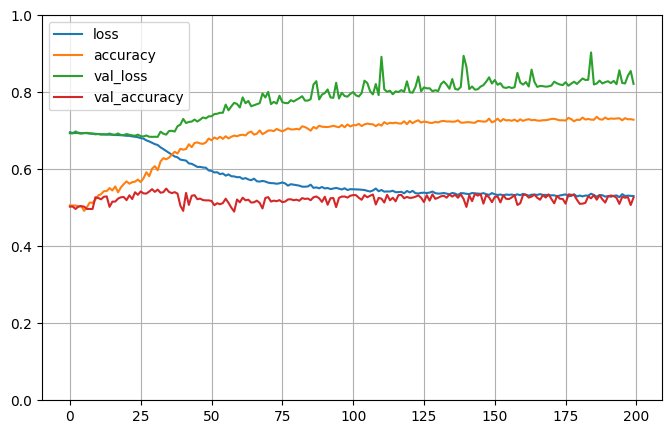


2023-04-04 14:20:21.687683

Testing # 1 5
2023-04-04 14:20:21.690194
2023-04-04 14:20:21.690678
PREDICT
2023-04-04 14:20:21.725356
Test 1:0 2302:2274 50.31%
Predict 1:0 2333:2243 50.98%
Test sizes (4576, 1025) (4576,)
Range of scores: 0.0029015199 to 0.9993736
Score threshold 0.5
Confusion matrix
 [[1175 1099]
 [1068 1234]]
Normalized matrix
 [[0.25677448 0.24016608]
 [0.23339161 0.26966783]]


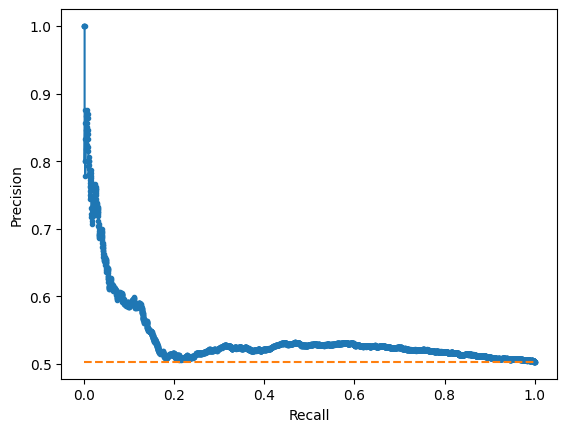

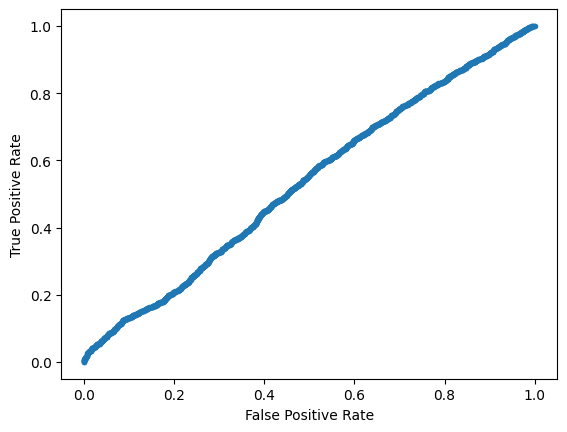

Accuracy: 52.64% Precision: 52.89% Recall: 53.61%
F1: 53.25% MCC: 0.0528
AUPRC: 53.87% AUROC: 53.36%
 accuracy [52.644230769230774]
 precision [52.8932704672096]
 recall [53.60556038227629]
 F1 [53.24703344120819]
 MCC [0.05277546643707251]
 AUPRC [53.866614298971015]
 AUROC [53.356818704548914]
2023-04-04 14:20:22.973057

Training # 2 1
2023-04-04 14:20:22.973891
2023-04-04 14:20:22.973974
Discriminator ZERO -1
Train 1:0 8949:6399 58.31%
Computed class weights: {0: 1.1992498827941867, 1: 0.8575259805564868}
Valid 1:0 2602:1839 58.59%
FIT
2023-04-04 14:20:23.148541


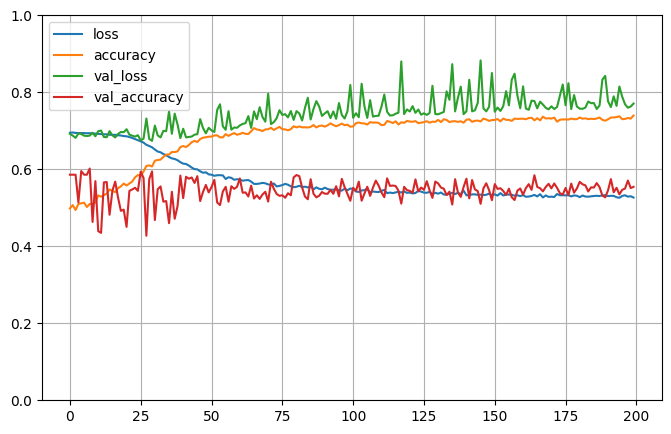


2023-04-04 14:25:57.180434

Testing # 2 1
2023-04-04 14:25:57.180841
2023-04-04 14:25:57.180905
PREDICT
2023-04-04 14:25:57.217457
Test 1:0 2602:1839 58.59%
Predict 1:0 2501:1940 56.32%
Test sizes (4441, 1025) (4441,)
Range of scores: 0.0001609187 to 0.9981628
Score threshold 0.5
Confusion matrix
 [[ 900  939]
 [1040 1562]]
Normalized matrix
 [[0.20265706 0.21143887]
 [0.23418149 0.35172259]]


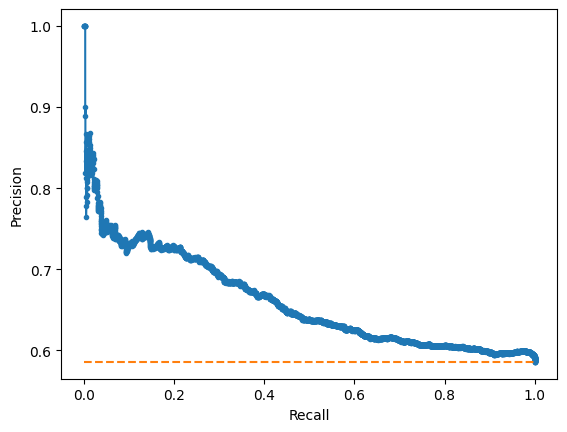

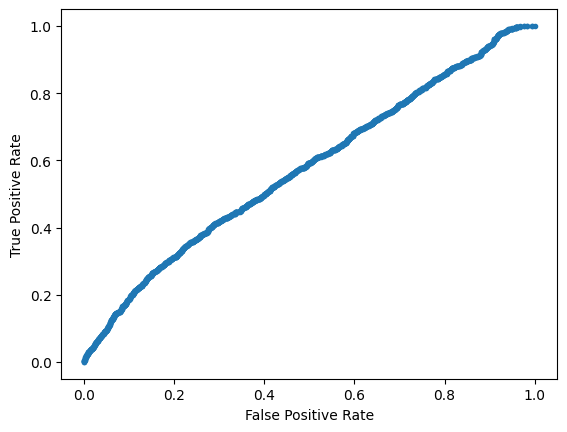

Accuracy: 55.44% Precision: 62.46% Recall: 60.03%
F1: 61.22% MCC: 0.0891
AUPRC: 66.05% AUROC: 57.67%
 accuracy [55.43796442242738]
 precision [62.45501799280287]
 recall [60.03074558032283]
 F1 [61.21889084852048]
 MCC [0.08908364213948627]
 AUPRC [66.04538117613967]
 AUROC [57.67367846459346]
2023-04-04 14:25:58.492819

Training # 2 2
2023-04-04 14:25:58.494940
2023-04-04 14:25:58.495012
Discriminator ZERO -1
Train 1:0 9334:6367 59.45%
Computed class weights: {0: 1.2329982723417623, 1: 0.8410649239340047}
Valid 1:0 2217:1871 54.23%
FIT
2023-04-04 14:25:58.684620


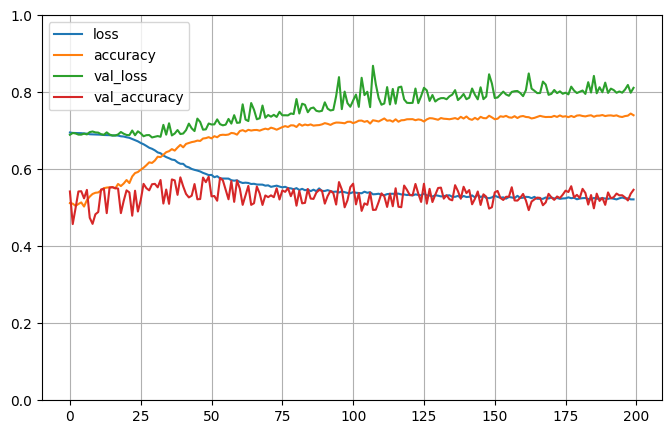


2023-04-04 14:32:22.014628

Testing # 2 2
2023-04-04 14:32:22.015065
2023-04-04 14:32:22.015147
PREDICT
2023-04-04 14:32:22.048528
Test 1:0 2217:1871 54.23%
Predict 1:0 2898:1190 70.89%
Test sizes (4088, 1025) (4088,)
Range of scores: 0.0010710633 to 0.998289
Score threshold 0.5
Confusion matrix
 [[ 604 1267]
 [ 586 1631]]
Normalized matrix
 [[0.14774951 0.30993151]
 [0.14334638 0.3989726 ]]


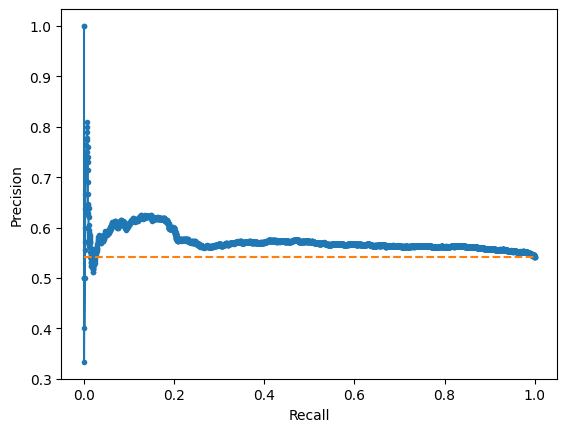

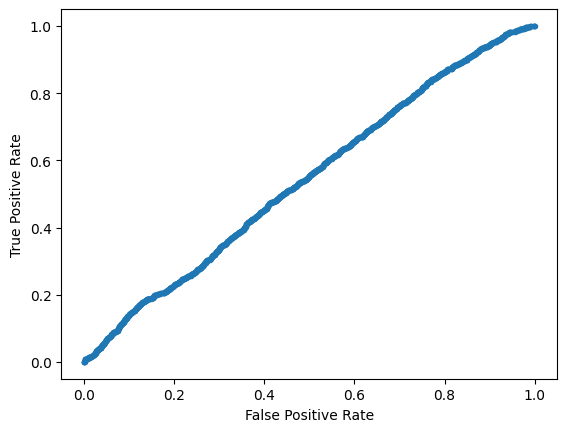

Accuracy: 54.67% Precision: 56.28% Recall: 73.57%
F1: 63.77% MCC: 0.0642
AUPRC: 57.33% AUROC: 54.35%
 accuracy [54.672211350293544]
 precision [56.28019323671497]
 recall [73.56788452864231]
 F1 [63.773216031280555]
 MCC [0.06415926219902619]
 AUPRC [57.32520108133463]
 AUROC [54.348642613187494]
2023-04-04 14:32:23.893985

Training # 2 3
2023-04-04 14:32:23.896011
2023-04-04 14:32:23.896068
Discriminator ZERO -1
Train 1:0 9380:6631 58.58%
Computed class weights: {0: 1.2072839692354094, 1: 0.8534648187633262}
Valid 1:0 2171:1607 57.46%
FIT
2023-04-04 14:32:24.074259


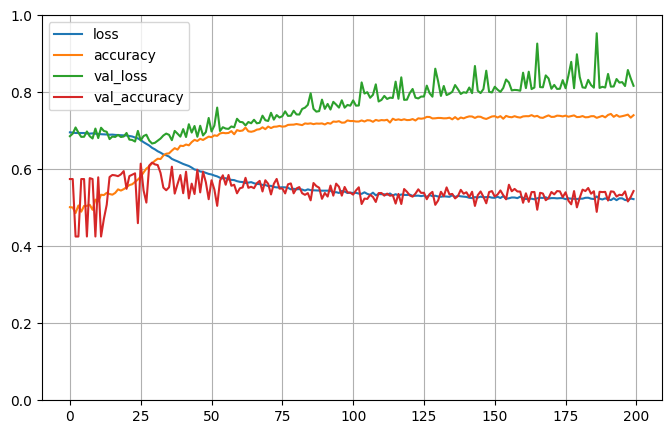


2023-04-04 14:38:16.378360

Testing # 2 3
2023-04-04 14:38:16.378534
2023-04-04 14:38:16.378595
PREDICT
2023-04-04 14:38:16.416796
Test 1:0 2171:1607 57.46%
Predict 1:0 2370:1408 62.73%
Test sizes (3778, 1025) (3778,)
Range of scores: 0.0015907148 to 0.9978693
Score threshold 0.5
Confusion matrix
 [[ 645  962]
 [ 763 1408]]
Normalized matrix
 [[0.17072525 0.25463208]
 [0.20195871 0.37268396]]


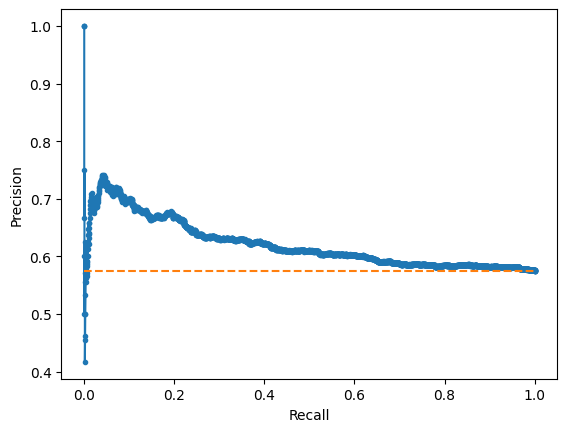

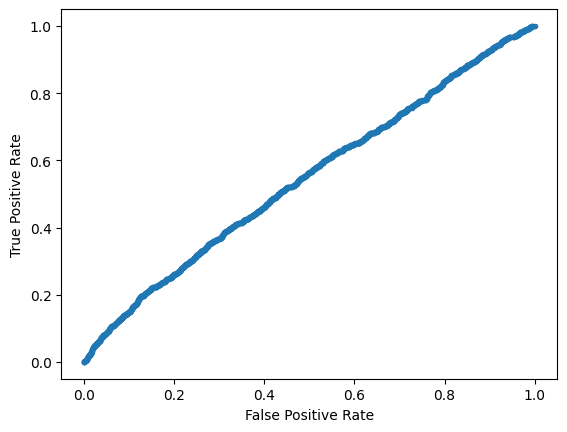

Accuracy: 54.34% Precision: 59.41% Recall: 64.85%
F1: 62.01% MCC: 0.0510
AUPRC: 62.06% AUROC: 54.67%
 accuracy [54.34092112228692]
 precision [59.40928270042194]
 recall [64.85490557346844]
 F1 [62.01277251706673]
 MCC [0.051041109159720516]
 AUPRC [62.057327788333026]
 AUROC [54.67317244310861]
2023-04-04 14:38:17.696839

Training # 2 4
2023-04-04 14:38:17.697084
2023-04-04 14:38:17.697142
Discriminator ZERO -1
Train 1:0 9581:6646 59.04%
Computed class weights: {0: 1.220809509479386, 1: 0.8468322722054066}
Valid 1:0 1970:1592 55.31%
FIT
2023-04-04 14:38:17.895616


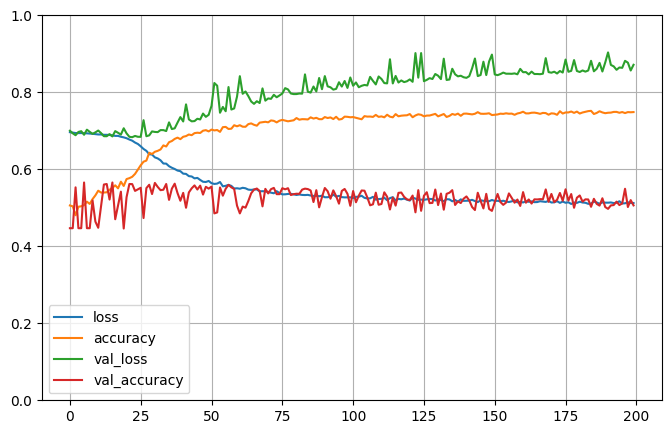


2023-04-04 14:44:41.248033

Testing # 2 4
2023-04-04 14:44:41.248465
2023-04-04 14:44:41.248526
PREDICT
2023-04-04 14:44:41.278388
Test 1:0 1970:1592 55.31%
Predict 1:0 1619:1943 45.45%
Test sizes (3562, 1025) (3562,)
Range of scores: 6.939725e-05 to 0.99921775
Score threshold 0.5
Confusion matrix
 [[ 888  704]
 [1055  915]]
Normalized matrix
 [[0.24929815 0.19764177]
 [0.29618192 0.25687816]]


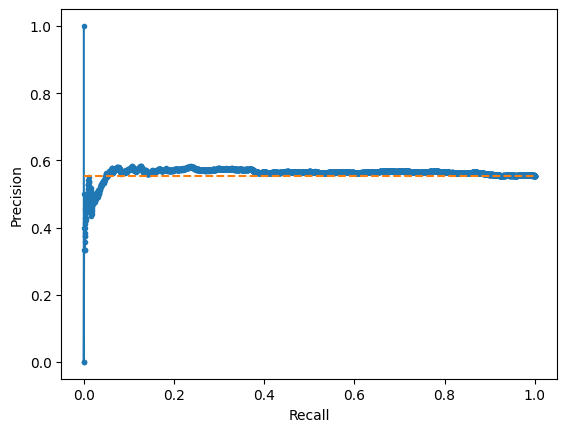

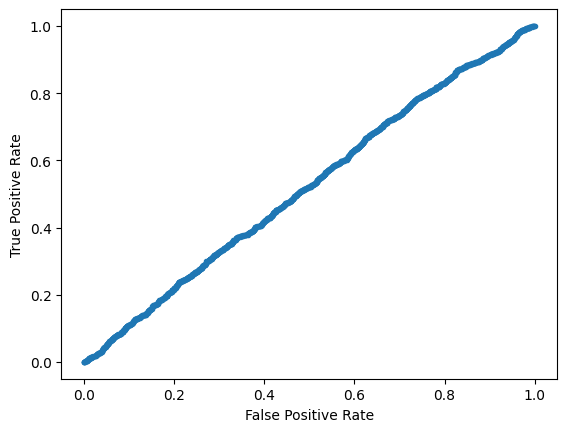

Accuracy: 50.62% Precision: 56.52% Recall: 46.45%
F1: 50.99% MCC: 0.0222
AUPRC: 56.27% AUROC: 52.15%
 accuracy [50.61763054463785]
 precision [56.51636812847437]
 recall [46.44670050761421]
 F1 [50.98913346336027]
 MCC [0.022222399621265074]
 AUPRC [56.270667522198224]
 AUROC [52.14667882560008]
2023-04-04 14:44:42.586831

Training # 2 5
2023-04-04 14:44:42.587728
2023-04-04 14:44:42.587801
Discriminator ZERO -1
Train 1:0 8960:6909 56.46%
Computed class weights: {0: 1.1484295845997974, 1: 0.885546875}
Valid 1:0 2591:1329 66.10%
FIT
2023-04-04 14:44:42.758258


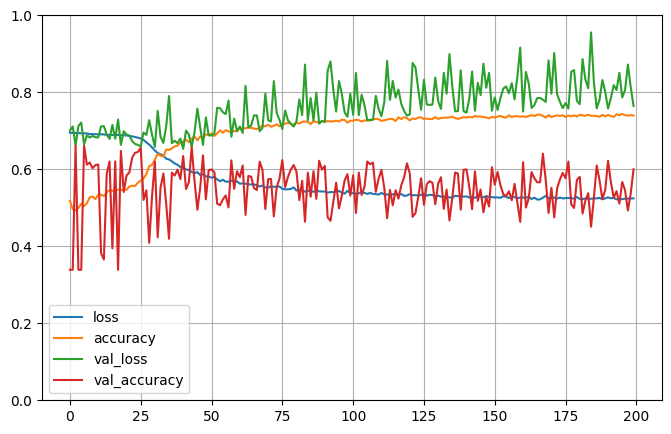


2023-04-04 14:51:06.000316

Testing # 2 5
2023-04-04 14:51:06.000470
2023-04-04 14:51:06.000541
PREDICT
2023-04-04 14:51:06.035683
Test 1:0 2591:1329 66.10%
Predict 1:0 2887:1033 73.65%
Test sizes (3920, 1025) (3920,)
Range of scores: 0.0009322717 to 0.9999972
Score threshold 0.5
Confusion matrix
 [[ 397  932]
 [ 636 1955]]
Normalized matrix
 [[0.10127551 0.2377551 ]
 [0.1622449  0.49872449]]


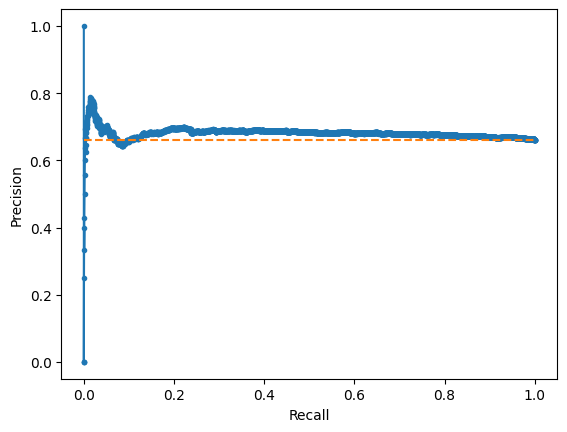

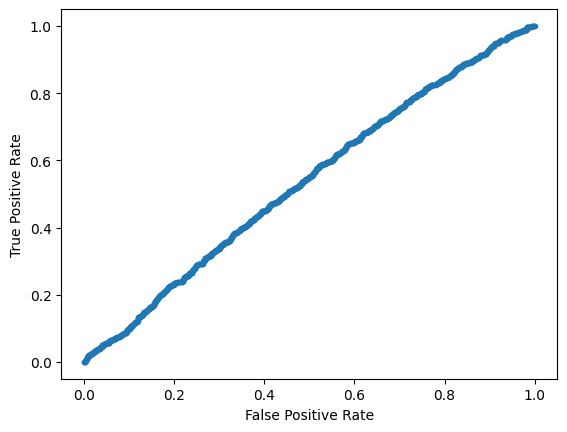

Accuracy: 60.00% Precision: 67.72% Recall: 75.45%
F1: 71.38% MCC: 0.0572
AUPRC: 68.09% AUROC: 53.65%
 accuracy [60.0]
 precision [67.71735365431243]
 recall [75.45349285989965]
 F1 [71.37641474990873]
 MCC [0.057225464099879664]
 AUPRC [68.08852317674159]
 AUROC [53.654558712961084]
2023-04-04 14:51:06.826002


In [11]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [12]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 54.80% std 2.76
 precision mean 60.54% std 4.70
 recall mean 63.93% std 10.32
 F1 mean 61.85% std 6.28
 MCC mean 0.05% std 0.02
 AUPRC mean 62.11% std 5.24
 AUROC mean 54.36% std 2.14
 accuracy [[53.16353887399464], [56.93156179493607], [52.708678828081815], [57.48194014447885], [52.644230769230774], [55.43796442242738], [54.672211350293544], [54.34092112228692], [50.61763054463785], [60.0]]
 precision [[66.64951106536284], [60.83868785931688], [58.93403232852774], [63.67392937640871], [52.8932704672096], [62.45501799280287], [56.28019323671497], [59.40928270042194], [56.51636812847437], [67.71735365431243]]
 recall [[54.09356725146199], [76.26112759643917], [63.632075471698116], [71.33838383838383], [53.60556038227629], [60.03074558032283], [73.56788452864231], [64.85490557346844], [46.44670050761421], [75.45349285989965]]
 F1 [[59.71869956190916], [67.68246802106847], [61.19301428895441], [67.28860658991664], [53.24703344120819], [61.21889084852048], [63.77321603128055